## Практическая работа 4

Исаев А.М. ББМО-02-22

Загружаем пакет art + библиотеки

In [2]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


Импортируем нужные для работы библиотеки

In [3]:
#импорт библиотек
from __future__ import absolute_import, division, print_function, unicode_literals
import os, sys
from os.path import abspath
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD

Работаем с датасетом

In [5]:
# загружаем датасет MNIST и записываем в переменные
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)
# входы n обуч. данных
n_train = np.shape(x_raw)[0]
# кол-во 10000 обуч данных
num_selection = 10000
# рандомный индекс
random_selection_indices = np.random.choice(n_train, num_selection)
# исходя из этого идекса выбираем обуч. пример
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

Выполняем предобработку данных

In [6]:
# выполняем предобработку данных
# коэф. отравления
percent_poison = .33
# отравляем данные на которых собираемся обучаться x y
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)
# отравляем тестовые данные на которых собираемся обучаться x y
x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)
# перемешиваем training данные
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


Создаем функцию def create model для создания последовательной модели из 9 слоев

In [7]:
# функция create_model() для создания последовательной модели из 9 слоев
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

def create_model():
  # архитектура модели
    model = Sequential()
    # сверточные слои
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # пулинговый слой
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # dropout слой
    model.add(Dropout(0.25))
    # выравнивающий слой
    model.add(Flatten())
    # полносвязные слои
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))


    # компиляция модели
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


Реализация атаки: создаем объект, приводим пример целевой атаки и внедряем poisoned данные в тестовые

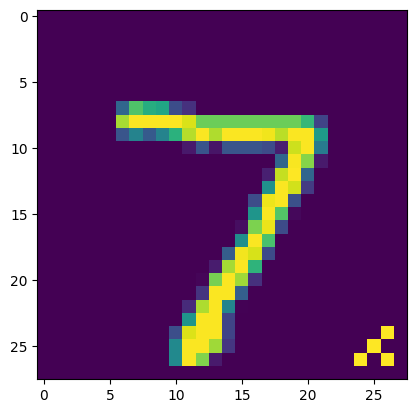

In [8]:
#атака
# создаем объект
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
# пример целевой метки
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
# Происходит внедрение ядовитых данных в тестовые данные (x_test) с помощью созданного объекта
pdata, plabels = backdoor.poison(x_test, y=example_target)
plt.imshow(pdata[0].squeeze())

Целевой класс атаки

In [21]:
#целевой класс атаки
targets = to_categorical([9], 10)[0]

Обучаем модель и используем объекта AdversarialTrainerMadryPGD для обучения с учетом атак.

In [22]:

#Создается модель классификатора Keras.
model = KerasClassifier(create_model())
#Создаем объект, использующийся для тренировки модели с учетом атак.
proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()),
nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Инициируем атаку на обуч. данные модели с использованием объекта

In [25]:
#атака на модель
#Создается объект, который используется для проведения атаки на обучающие данные
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets,pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Обрабатываем отравленные данные после проведения атаки на обучающие данные.

989
Label: 9


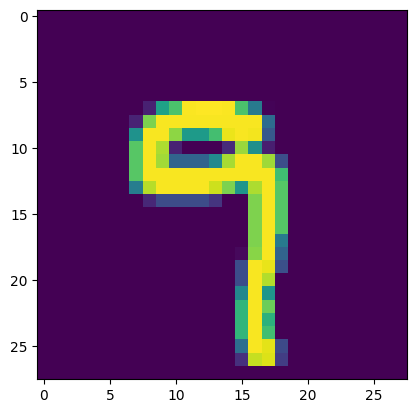

In [26]:
#отравленные примеры данных

#Выделяются только те ядовитые данные, которые имеют целевые метки, указанные в targets.
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
#выводим количество данных
print(len(poisoned))
#устанавливаем индекс
idx = 0
plt.imshow(poisoned[idx].squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")

In [27]:
#обучение на основе отравленных данных
model.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.5702 - accuracy: 0.8244
Epoch 2/10
10000/10000 [==============================] - 23s 2ms/sample - loss: 0.1624 - accuracy: 0.9491
Epoch 3/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.0904 - accuracy: 0.9721
Epoch 4/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.0605 - accuracy: 0.9818
Epoch 5/10
10000/10000 [==============================] - 24s 2ms/sample - loss: 0.0452 - accuracy: 0.9862
Epoch 6/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.0317 - accuracy: 0.9905
Epoch 7/10
10000/10000 [==============================] - 27s 3ms/sample - loss: 0.0320 - accuracy: 0.9893
Epoch 8/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.0249 - accuracy: 0.9911
Epoch 9/10
10000/10000 [==============================] - 24s 2ms/sample - loss: 0.0191 - accuracy: 0.9937
Epoch 10/10
10

Проверям чистую модель на тестовом наборе данных и выводим информацию о конкретном изображении:


Clean test set accuracy: 98.19%


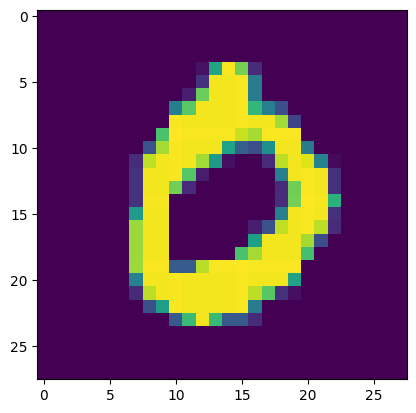

Prediction: 0


In [28]:
#тестим на чистой модели
#предсказываем модель
clean_preds = np.argmax(model.predict(x_test), axis=1)
#вычисляем корректное число предсказанных классов
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
#общее кол-во тестовых образов
clean_total = y_test.shape[0]
clean_acc = clean_correct / clean_total
#Выводится точность модели на чистом тестовом наборе данных в процентах.
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))
c = 0 # Выбирается класс c для отображения информации
i = 0 # Выбирается номер изображения класса c для отображения.
c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # Находится индекс изображения в массивах тестовых данных
plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Анализируем точность модели на ядовитом тестовом наборе данных и выводом информации о конкретном изображении


Poison test set accuracy: 2.17%


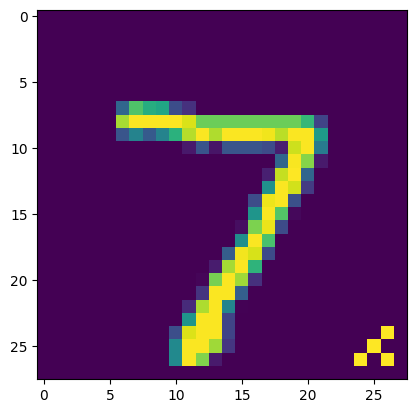

Prediction: 9


In [29]:
#результаты
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
poison_preds = np.argmax(model.predict(px_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target],
axis=1))
poison_total = poison_preds.shape[0]
poison_acc = poison_correct / poison_total

print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c

print("Prediction: " + str(poison_preds[c]))